In [1]:
import glob
import pandas as pd
import json
import pickle as pkl

import numpy as np
import matplotlib.pyplot as plt
import hist
import mplhep
import matplotlib as mpl
from matplotlib.lines import Line2D

mpl.rcParams["font.size"] = 16
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["grid.color"] = "#CCCCCC"
mpl.rcParams["grid.linewidth"] = 0.5
mpl.rcParams["figure.edgecolor"] = "none"

import matplotlib.ticker as mticker
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
mplhep.style.use(["CMS", "firamath"])

In [2]:
def get_sum_sumgenweight(pkl_files, year, sample):
    sum_sumgenweight = 0
    for ifile in pkl_files:
        # load and sum the sumgenweight of each
        with open(ifile, "rb") as f:
            metadata = pkl.load(f)
        sum_sumgenweight = sum_sumgenweight + metadata[sample][year]["sumgenweight"]
    return sum_sumgenweight

def get_xsecweight(pkl_files, year, sample, is_data, luminosity):
    if not is_data:
        # find xsection
        f = open("../fileset/xsec_pfnano.json")
        xsec = json.load(f)
        f.close()
        try:
            xsec = eval(str((xsec[sample])))
        except ValueError:
            print(f"sample {sample} doesn't have xsecs defined in xsec_pfnano.json so will skip it")
            return None

        # get overall weighting of events.. each event has a genweight...
        # sumgenweight sums over events in a chunk... sum_sumgenweight sums over chunks
        xsec_weight = (xsec * luminosity) / get_sum_sumgenweight(pkl_files, year, sample)
    else:
        xsec_weight = 1
    return xsec_weight

In [21]:
eta_axis = hist.axis.Regular(
    40, -3, 3, name="eta", label=r"AK8 Jet $\eta$"
)
phi_axis = hist.axis.Regular(
    40, -3, 3, name="phi", label=r"AK8 Jet $\phi$"
)
channel_axis = hist.axis.StrCategory([], name="channel", growth=True)
sample_axis = hist.axis.StrCategory([], name="name", growth=True)
h_etaphi = hist.Hist(phi_axis, eta_axis, channel_axis, sample_axis)

odir = "/eos/uscms/store/user/cmantill/boostedhiggs/Jan6_2018/"
samples_dict = {
    "ggH": ["GluGluHToWW_Pt-200ToInf_M-125"],
    "VBF": ["VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil"],
    "QCD": [
        "QCD_Pt_170to300",
        "QCD_Pt_300to470",
        "QCD_Pt_470to600",
        "QCD_Pt_600to800",
        "QCD_Pt_800to1000",
        "QCD_Pt_1000to1400",
        "QCD_Pt_1400to1800",
        "QCD_Pt_1800to2400",
        "QCD_Pt_2400to3200",
        "QCD_Pt_3200toInf",
    ],
    "TT": [
        "TTTo2L2Nu",
        "TTToHadronic",
        "TTToSemiLeptonic",
    ],
    "WJets": [
        "WJetsToLNu_HT-200To400",
        "WJetsToLNu_HT-400To600",
        "WJetsToLNu_HT-600To800",
        "WJetsToLNu_HT-800To1200",
        "WJetsToLNu_HT-1200To2500",
        "WJetsToLNu_HT-2500ToInf",
    ],
    "data_ele": [
        "EGamma_Run2018A",
        "EGamma_Run2018B",
        "EGamma_Run2018C",
        "EGamma_Run2018D",
    ],
    "data_mu": [
        "SingleMuon_Run2018A",
        "SingleMuon_Run2018B",
        "SingleMuon_Run2018C",
        "SingleMuon_Run2018D",
    ],
}
year = "2018"

for ch in ["ele", "mu"]:
    for key,samples in samples_dict.items():
        print(key)
        if "data" in key and f"data_{ch}" != key: 
            print("here")
            continue

        for sample in samples:
            parquet_files = glob.glob(f"{odir}/{sample}/outfiles/*_{ch}.parquet")
            pkl_files = glob.glob(f"{odir}/{sample}/outfiles/*.pkl")

            if "data" not in key:
                data = pd.read_parquet(parquet_files, columns=["fj_phi", "fj_eta", f"weight_{ch}"])
                luminosity = 137640.0
                event_weight = get_xsecweight(pkl_files, year, sample, False, luminosity)
                event_weight *= data[f"weight_{ch}"]
            else:
                data = pd.read_parquet(parquet_files, columns=["fj_phi", "fj_eta"])
                event_weight = np.ones_like(data["fj_eta"].values)

            eta = data["fj_eta"].values
            phi = data["fj_phi"].values
            h_etaphi.fill(phi, eta, ch, key, weight=event_weight)

ggH
VBF
QCD
TT
WJets
data_ele
data_mu
here
ggH
VBF
QCD
TT
WJets
data_ele
here
data_mu


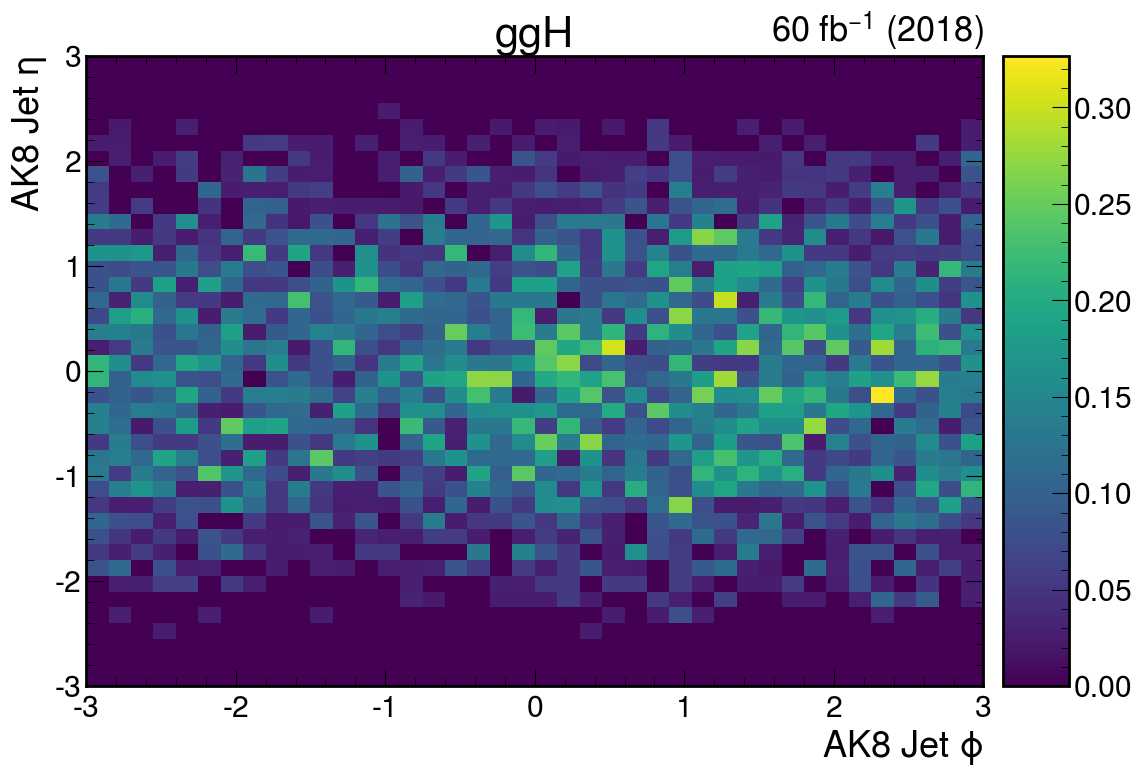

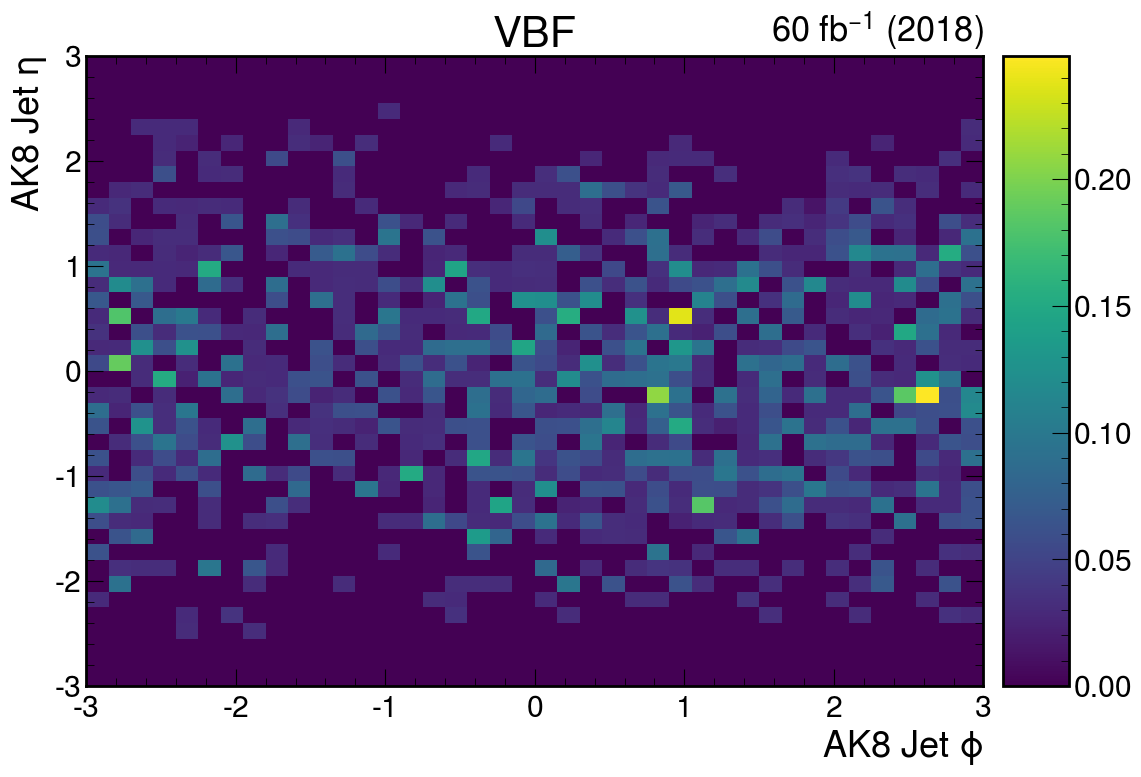

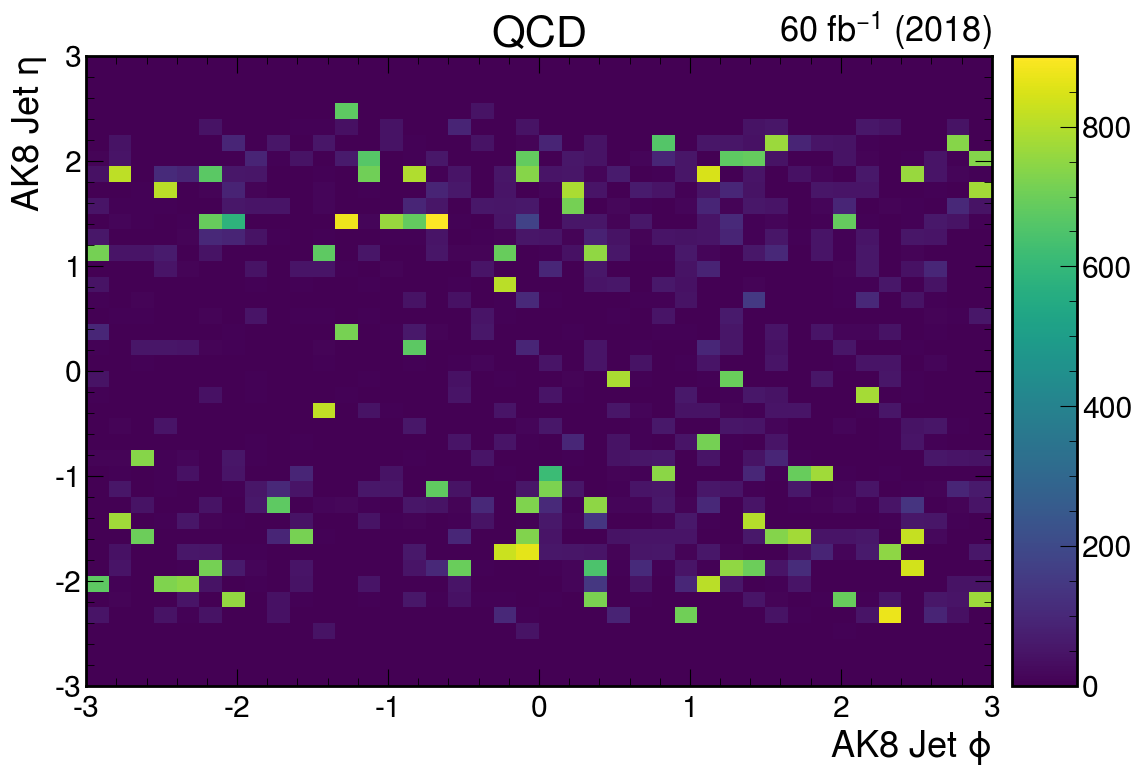

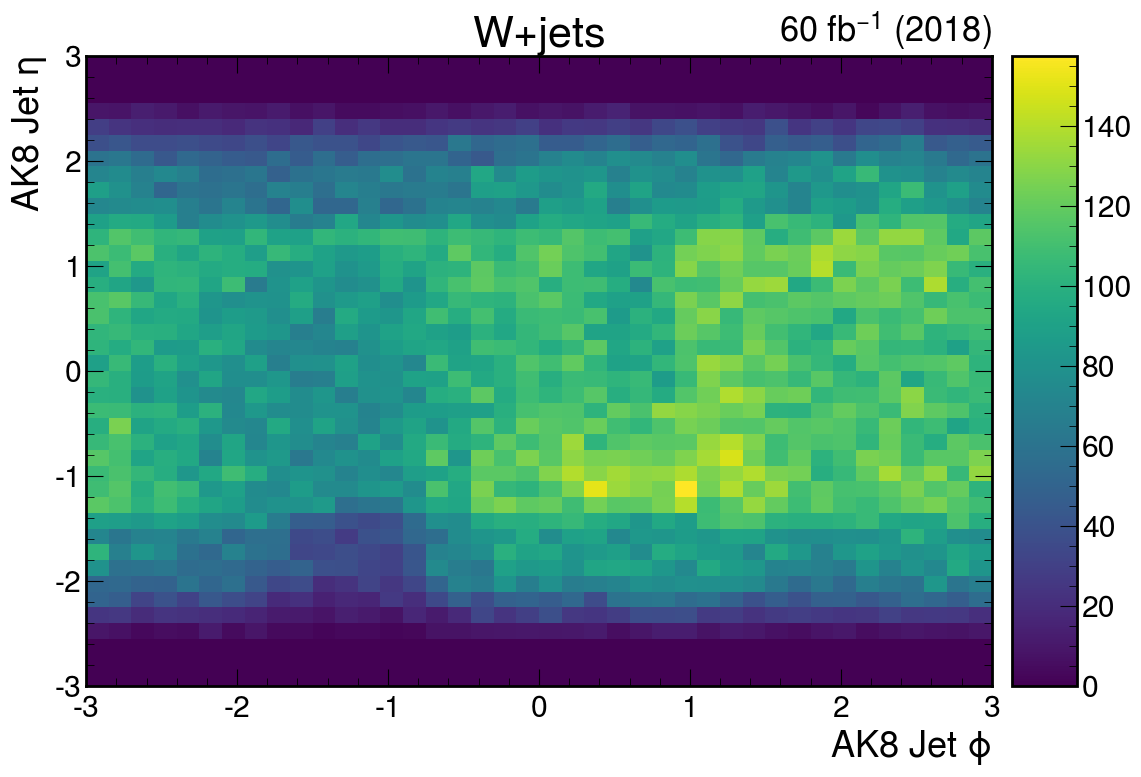

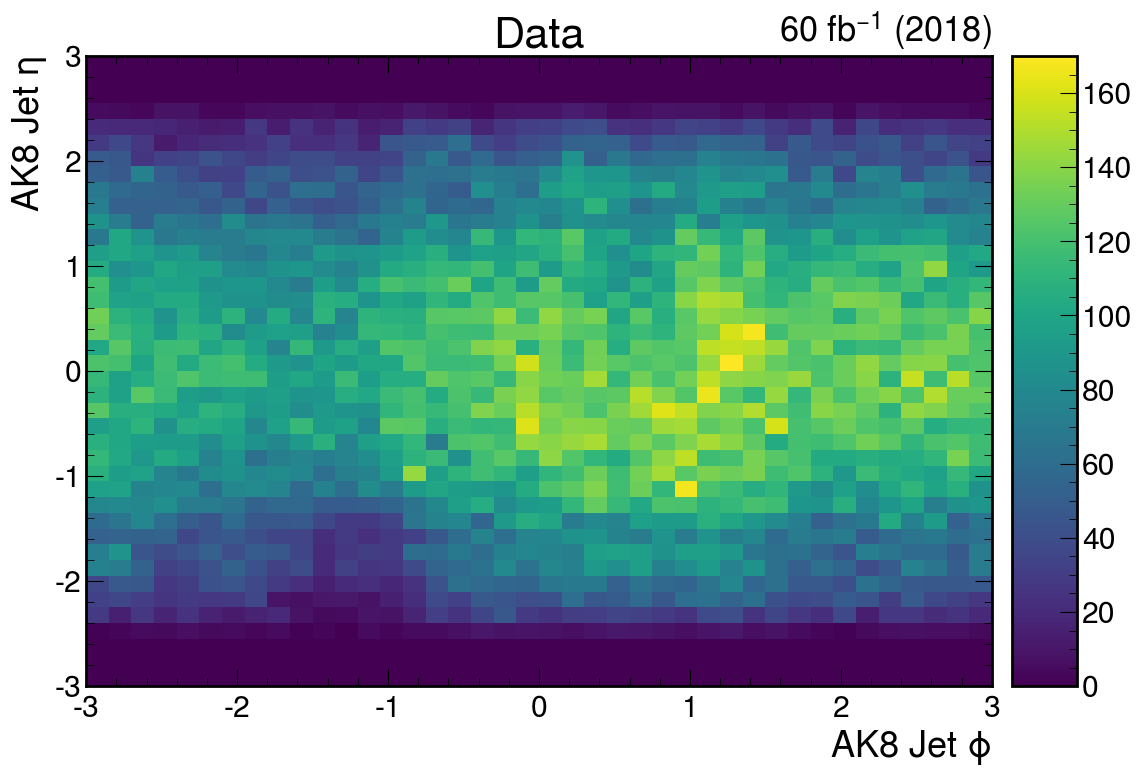

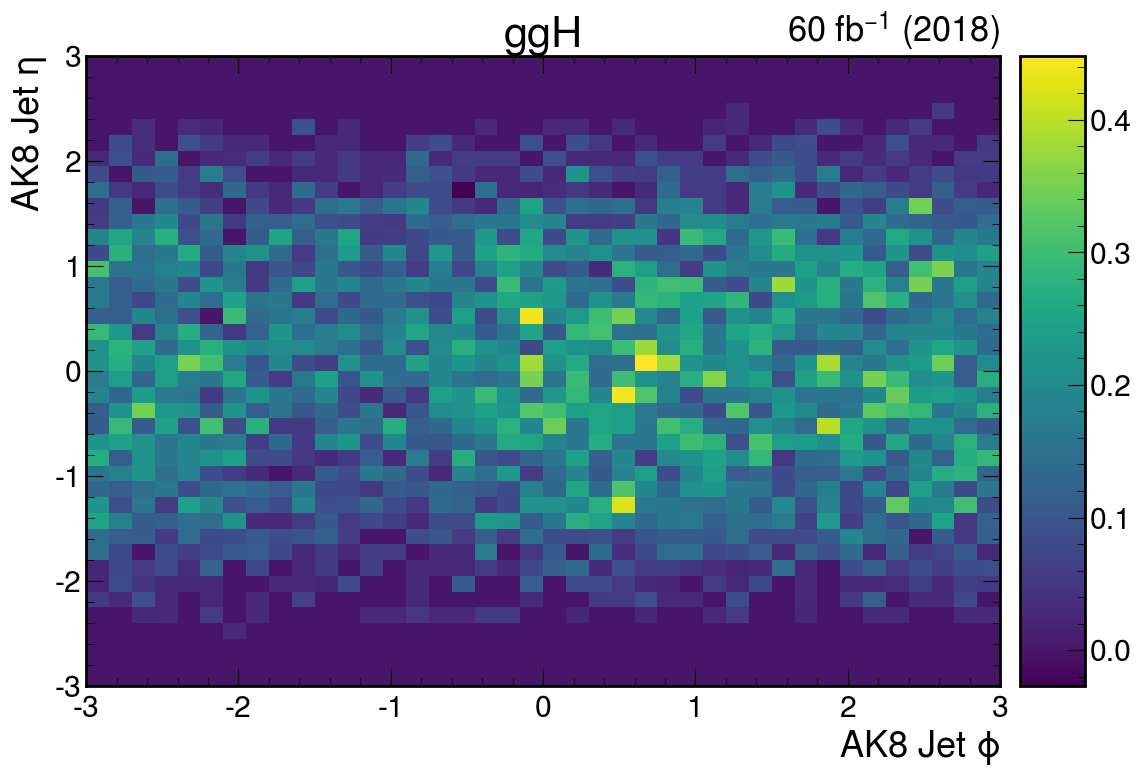

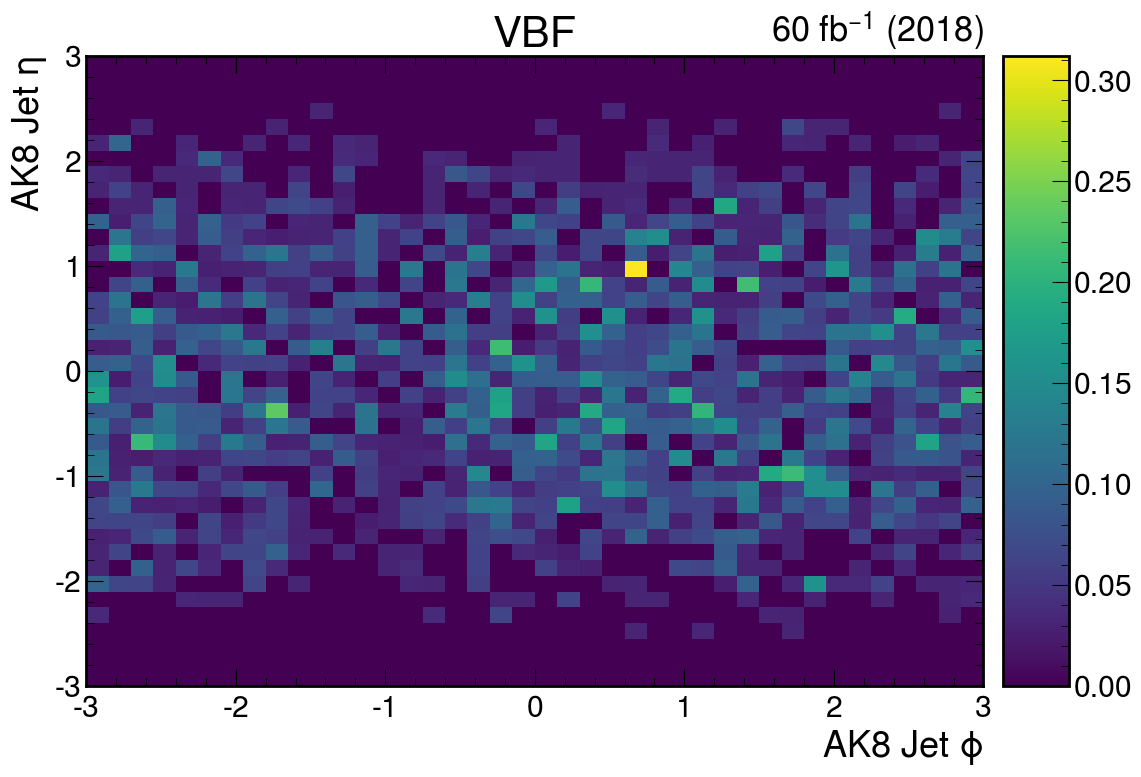

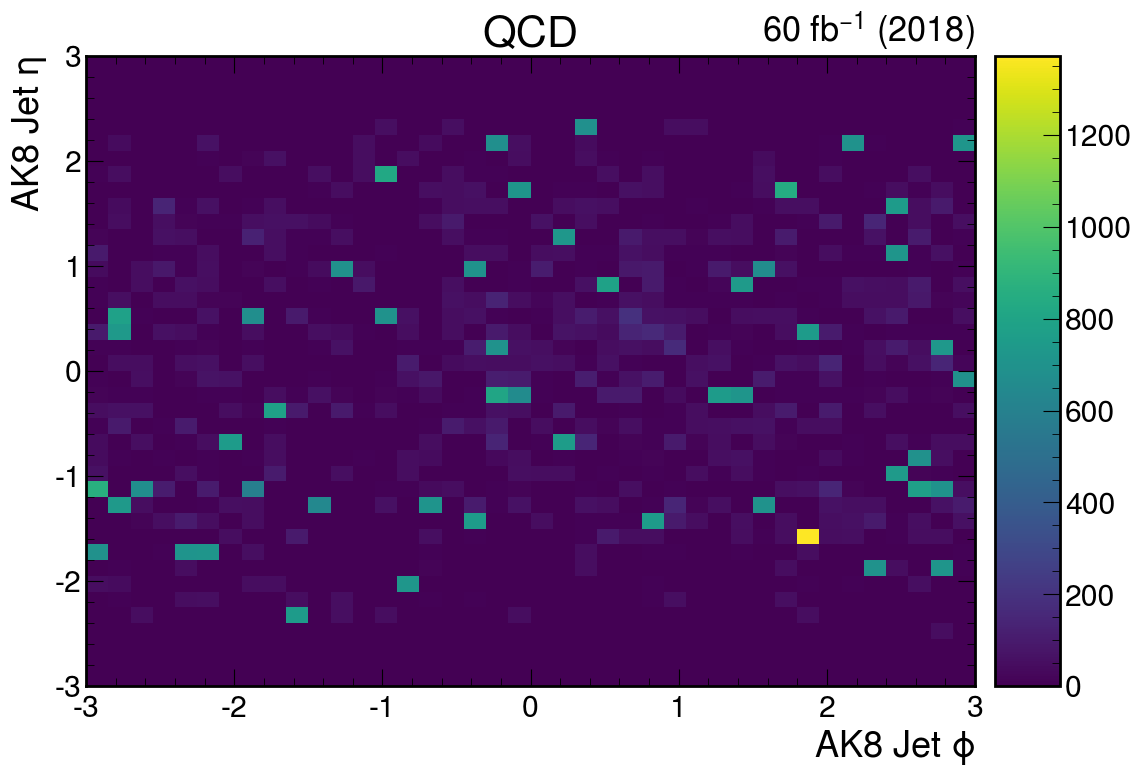

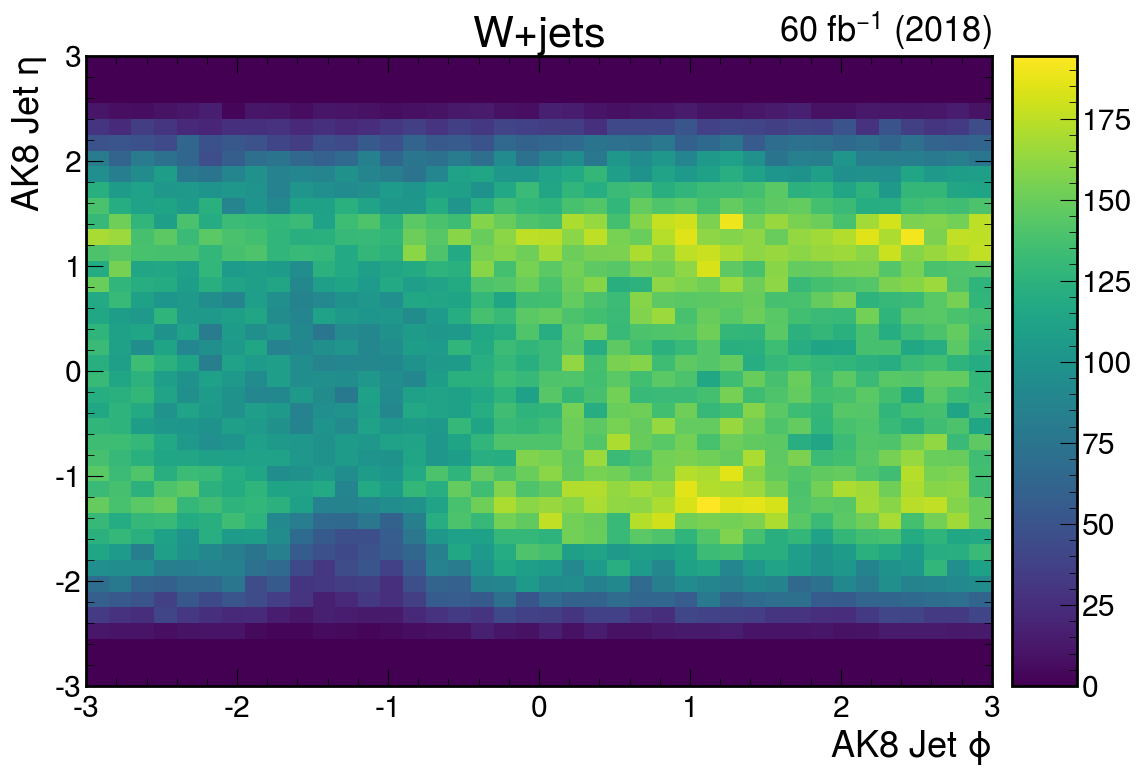

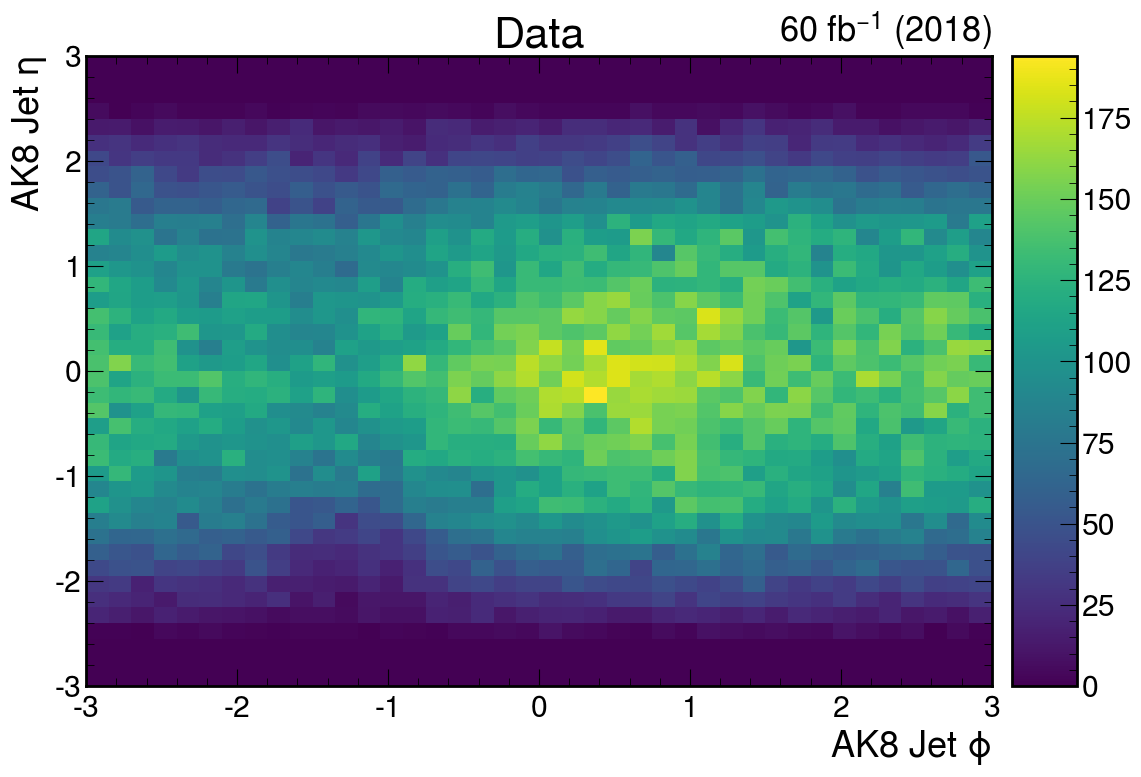

In [23]:
for ch in ["ele", "mu"]:
    names = {
    "ggH": "ggH",
    "VBF": "VBF",
    "QCD": "QCD",
    "WJets": "W+jets",
    f"data_{ch}": "Data",
    }
    for key in names.keys():
        fig, ax = plt.subplots(figsize=(12, 8))
        mplhep.hist2dplot(
            h_etaphi[{"name": key, "channel": ch}],
            lw=2,
            flow="none"
        )
        plt.tight_layout()
        mplhep.cms.lumitext(r"60 fb$^{-1}$ (2018)")
        ax.set_title(f"{names[key]}")
        fig.savefig(f"hem_{ch}_{key}.pdf")